# Method 1: Prediction based on images

## 1.Loading data files

Mount data from Google Drive

In [5]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
except:
  pass

Import necesary modules

In [1]:
!pip install pycm livelossplot

In [19]:
# import package functions
from forecaster.eda import *

# import module
import os
import json
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import torch.utils.data as data
from livelossplot import PlotLosses
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
from torch.utils.data import random_split

import matplotlib.pyplot as plt
from PIL import Image

import forecaster.read_data as rd
import forecaster.wind_speed_lstm as wp

import warnings
warnings.filterwarnings("ignore")

## EDA

Create a dataframe of features and labels.

In [21]:
storm_directory = './data'
final_df = rd.read_tabular_data(storm_directory)
df = final_df.copy()
final_df = final_df.drop(['id'], axis=1)
final_df.head()

Image amount distribution and difference between consecutive steps:

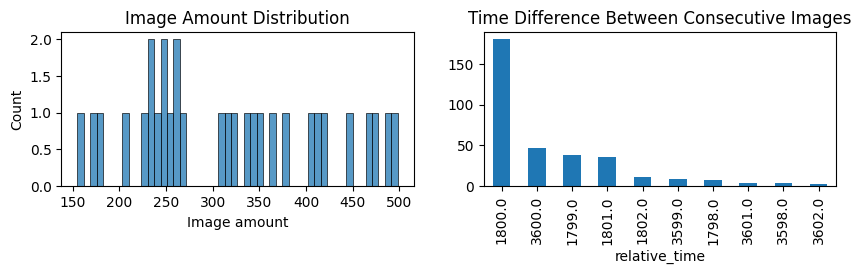

In [17]:
df_gkf = df[df['storm_id'] == 'gkf'].copy()
plt.figure(figsize=(10, 2))
plt.subplot(1, 2, 1), sns.histplot(df['storm_id'].value_counts(), bins=50)
plt.title('Image Amount Distribution'), plt.xlabel('Image amount'), plt.subplot(1, 2, 2)
df_gkf['relative_time'].diff().value_counts().plot(kind='bar', title='Time Difference Between Consecutive Images'), plt.show();


Plot the 4 different **fastest** and **lowest** speed storms.
- We see that independent of storms, there is a clear distinction between high speed and low speed storms. Thus, a CNN network should be able to capture these relationships.  
- Furthermore, we see that the biggest change happens in the middle. Thus, cropping the image could help.

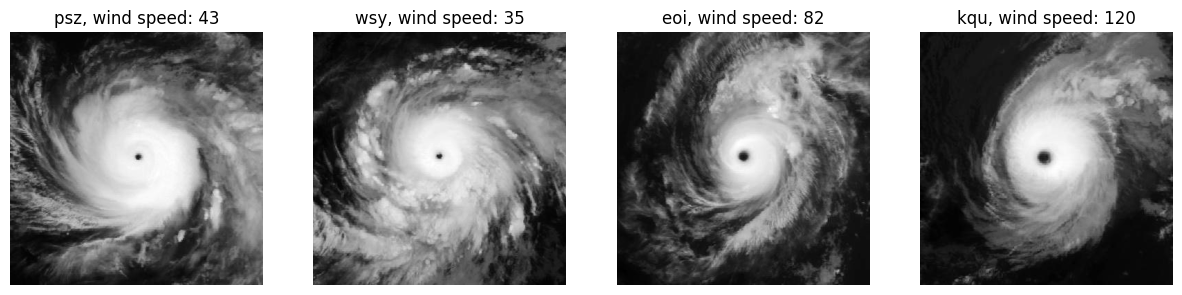

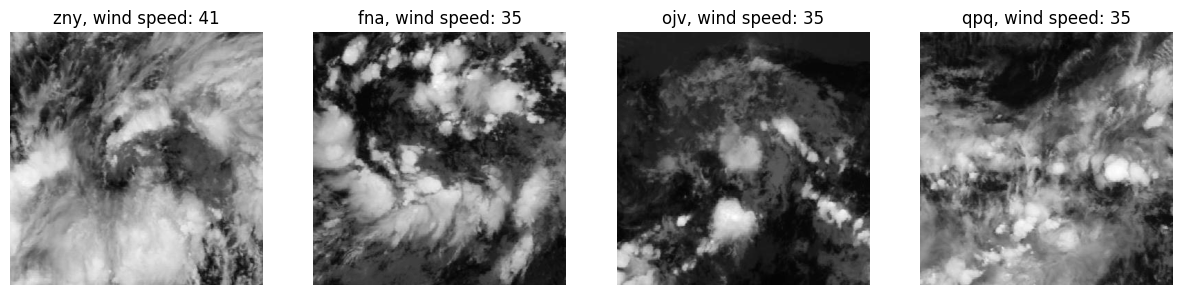

In [22]:
plot_images(df, storm_directory, ascending=False)
plot_images(df, storm_directory, ascending=True)

Now, we will investigate **ocean feature**. Below, we see that average wind speed in ocean 1 is less than ocean 2. Also, most of the storms happenned in ocean 1.
- Ocean feature seems to have no significant contribution to wind speed according to the above histogram.

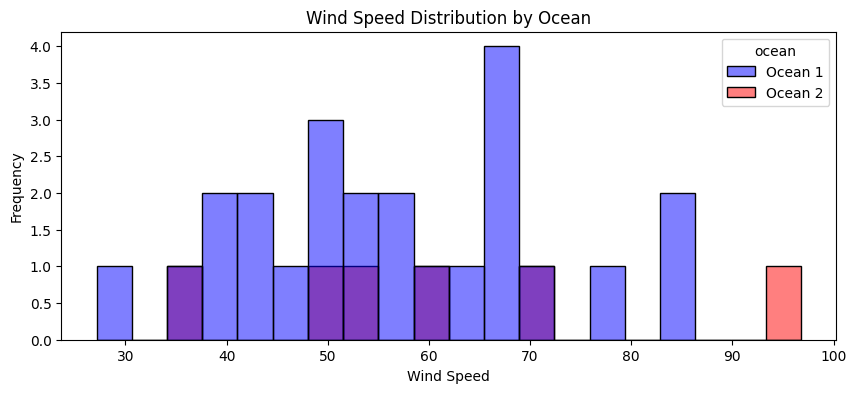

In [23]:
df_ocean_1 = df[df['ocean'] == '1'][['storm_id', 'wind_speed']].groupby('storm_id').mean()
df_ocean_2 = df[df['ocean'] == '2'][['storm_id', 'wind_speed']].groupby('storm_id').mean()
combined_df = pd.concat([df_ocean_1.assign(ocean='Ocean 1'), df_ocean_2.assign(ocean='Ocean 2')])
colors = {'Ocean 1': 'blue', 'Ocean 2': 'red'}
plt.figure(figsize=(10, 4))
sns.histplot(data=combined_df, x='wind_speed', bins=20, hue='ocean', kde=False, palette=colors)
plt.title('Wind Speed Distribution by Ocean'), plt.xlabel('Wind Speed'), plt.ylabel('Frequency'), plt.show();

Let's investigate time vs wind speed plots.
- It is seen that there are a variety of storms that follow different behaviours. Thus, either we need to train and predict our model on each storm or we need to create a generalisable model.

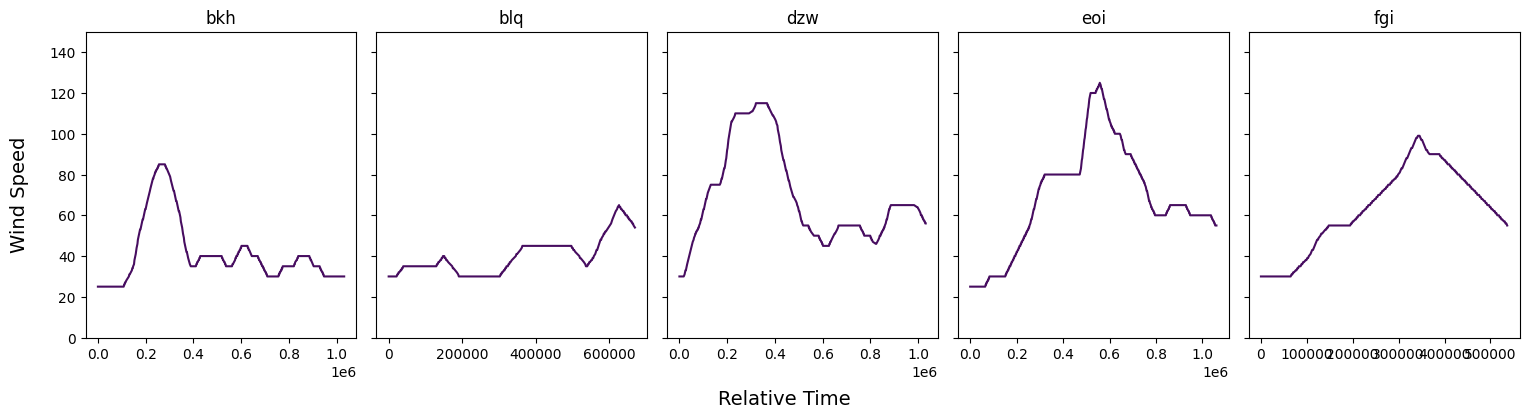

In [24]:
sns.set_palette("viridis", n_colors=len(df['storm_id'].unique()))
fig, ax = plt.subplots(1, 5, figsize=(15, 4), sharey=True)
for i, storm in enumerate(df['storm_id'].unique()[:5]):
    ax[i].plot(df.loc[df['storm_id']==storm]['relative_time'], df.loc[df['storm_id']==storm]['wind_speed'], label=storm)
    ax[i].set_title(storm)
    ax[i].set_ylim(0, 150)
plt.tight_layout(), fig.text(0.5, -0.01, 'Relative Time', ha='center', va='center', fontsize=14)
fig.text(-0.01, 0.5, 'Wind Speed', ha='center', va='center', rotation='vertical', fontsize=14), plt.show();



## 2.Data pre-processing


### 2.1 Speed normalization

We normalized the wind speed, reasons are as follows:
1. Uniform Scale: Neural networks tend to be sensitive to input data scale, and normalization helps in activating functions to work properly.

2. Improved Model Training: Deep learning algorithms assume that all features are on similar scales and centered around zero. Normalizing wind speed can speed up the learning process by helping the model converge faster.

3. Reduction of Dominance: If wind speed values are significantly higher than other features in the dataset, it might dominate the learning process, leading the model to underweight other features. Normalization ensures that all features contribute equally to the model's learning.

In [25]:
final_df_sorted = final_df.sort_values(by=['storm_id', 'relative_time'])
max_wind_speed = final_df_sorted['wind_speed'].max()
final_df_sorted['normalized_wind_speed'] = final_df_sorted['wind_speed'] / max_wind_speed

In [26]:
final_df_sorted

,storm_id,relative_time,ocean,wind_speed,normalized_wind_speed
5699,bkh,0,1,25,0.166667
6036,bkh,1801,1,25,0.166667
5964,bkh,3600,1,25,0.166667
5721,bkh,5400,1,25,0.166667
5685,bkh,7200,1,25,0.166667
...,...,...,...,...,...
1730,ztb,550801,1,44,0.293333
1788,ztb,552603,1,43,0.286667
1942,ztb,554401,1,42,0.280000
1957,ztb,556202,1,42,0.280000


### 2.2 Consistency between images and wind speed

Load and sort the image files, ensuring the sequence of image files corrospond to the sequence of the data frame.

In [ ]:
# Locate the directory containing the image
image_dir = './drive/MyDrive/Selected_Storms_curated'

# Get all subfolders under storm_directory, sorted by name in ascending order
storm_folders = sorted([d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d))])

# A list to store the paths of all images
image_files = []

# Iterate through each subfolder
for folder in storm_folders:
    # Use glob to match all images in the current folder that match the named format
    folder_images = glob(os.path.join(image_dir, folder, f'{folder}_*.jpg'))

    # Sort the images in the current folder in ascending order
    folder_images.sort()

    # Add these images to the master list
    image_files.extend(folder_images)


'''# Convert image file paths to DataFrame
image_files_df = pd.DataFrame(image_files, columns=['image_path'])

# Write DataFrame to CSV file
csv_file_path = 'image_files.csv'
image_files_df.to_csv(csv_file_path, index=False)'''

"# Convert image file paths to DataFrame\nimage_files_df = pd.DataFrame(image_files, columns=['image_path'])\n\n# Write DataFrame to CSV file\ncsv_file_path = 'image_files.csv'\nimage_files_df.to_csv(csv_file_path, index=False)"

### 2.3 Image Transformation

We first define a transform object to pre-process the images. The transformations are defined using PyTorch's transforms module and are composed together in a specific sequence.

1. Resize 366x366 pixel images into 128x128 because of a limited computational power.
2. ToTensor Transformation
3. Normalizes the tensor image. The normalization is performed channel-wise (for grayscale channels) using the specified mean and standard deviation. This normalization helps to standardize the input data distribution, making the training process more stable and efficient.

We have tried additional transformation in our experiments, but find the best transform is the following one. In the "Model Comparison" Module, we illustrates the experimental results.

In [ ]:
# Define a transformation for the images
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize the image to 128x128
    # transforms.RandomRotation(degrees=15),  # Randomly rotate the image by +/- 15 degrees
    # transforms.RandomHorizontalFlip(p=0.2),  # Randomly flip the image horizontally with a probability of 0.5
    # transforms.RandomVerticalFlip(p=0.2),  # Randomly flip the image vertically with a probability of 0.5
    # transforms.ColorJitter(contrast=0.5),  # Randomly change the contrast of the image
    # transforms.RandomResizedCrop(128, scale=(0.8, 1.0), ratio=(0.75, 1)),  # Randomly crop and resize the image
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    # transforms.CenterCrop(256),  # Crop the image to 128x128 at the center
    # transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),  # Normalize the tensor
    transforms.Normalize(mean=[0.485], std=[0.229]),  # Normalize the tensor
])

### 2.4 Custom Dataset

Custom Dataset of task2.
1. We convert all the images to grayscale instead on RGB, because we find grayscale images produce a better performance.
2. For the features, we only take `wind_speed` into consideration, because we found `ocean` does not have close connection between wind speed in our experimental process.

In [ ]:
# A custom dataset class that we would use if we had multiple images
class StormDataset(Dataset):
    def __init__(self, image_paths, wind_speeds, transform=None):
        self.image_paths = image_paths
        self.wind_speeds = wind_speeds
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        # image = Image.open(image_path).convert('RGB')
        image = Image.open(image_path).convert('L')
        wind_speed = self.wind_speeds[idx]

        if self.transform:
            image = self.transform(image)

        return image, wind_speed


### 2.5 Data split

Load data into dataloader. We random split the data into 80% and 20%, respectively for training and testing.


1. Dataset: 30 storm types, totally 9748 images
2. Training set: 80% Dataset, random split
3. Testing set: 20% Dataset

In [ ]:
wind_speeds = final_df_sorted['normalized_wind_speed']

# Create a StormDataset instance
storm_dataset = StormDataset(image_files, wind_speeds, transform=transform)

# Get the size of the entire dataset
dataset_size = len(storm_dataset)

# Calculate the size of the training and test sets
train_size = int(dataset_size * 0.8)
test_size = dataset_size - train_size

batch_size = 32

train_dataset, test_dataset = random_split(storm_dataset, [train_size, test_size])

# Create DataLoader for training and test sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## 3.Architecture

The final model we used is a 6-layer CNN model. The model is structured as follows:

1. **Convolutional Layers**: It consists of six convolutional layers (Conv2d) designed for feature extraction from input images. Each convolutional layer is followed by batch normalization (BatchNorm2d) and a ReLU activation function for non-linear transformations. After each pair of convolutional layers, a max-pooling layer (MaxPool2d) is applied to reduce the spatial dimensions of the output.

2. **Fully Connected Layers**: It starts with flattening the output from the convolutional layers. This is followed by three linear layers (Linear) with ReLU activations for further processing of the features. Additionally, a dropout layer with a 50% drop rate (Dropout(0.5)) is included before the final linear layer to prevent overfitting.

3. **Output**: The final linear layer outputs the predictions. The number of output features of this layer is determined by num_classes, making the network adaptable for different classification tasks.

In [ ]:
class Simple6LayerCNNv3(nn.Module):
    def __init__(self, num_classes=1):
        super(Simple6LayerCNNv3, self).__init__()
        # Define 6 cnn layers with Batch Normalization
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),  # Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),  # Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),  # Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),  # Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),  # Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),  # Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Define fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

Initialize a modela and load to GPU

In [ ]:
# Initialize the CNN model
cnn_model = Simple6LayerCNNv3()

# Check if a GPU is available and if so, move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model.to(device)

Simple6LayerCNNv3(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_

## 4.Model Training

Training configuration:

1. batch_size = 32 (depends on the length of dataset)
2. loss function: MSE loss
3. optimizer: Adam
4. Learning_rate = 0.001
5. epoch = 50

We choose Mean Square Error as the loss function because:

1. **Sensitive to large errors**: MSE squares the errors before averaging them, which naturally gives more weight to larger errors. So models are penalized more for making bigger mistakes, which is often desirable in predictive modeling.

2. **Differentiability**: MSE is a smooth and differentiable function, which allows for efficient optimization using gradient descent and other gradient-based optimization algorithms.

3. **Consistency with Variance**: MSE is closely related to the statistical measure of variance. When a model’s predictions are unbiased, the MSE is equivalent to the variance of the errors. It can provide insights into the variability of the model's predictions.

In [ ]:
# Define the loss function and optimizer
batch_size = 32
criterion = nn.MSELoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

Training process

epoch: 1, iteration:     1, loss: 0.000
epoch: 1, iteration:    51, loss: 0.162
epoch: 1, iteration:   101, loss: 0.032
epoch: 1, iteration:   151, loss: 0.028
epoch: 1, iteration:   201, loss: 0.029
epoch: 2, iteration:     1, loss: 0.001
epoch: 2, iteration:    51, loss: 0.028
epoch: 2, iteration:   101, loss: 0.027
epoch: 2, iteration:   151, loss: 0.026
epoch: 2, iteration:   201, loss: 0.024
epoch: 3, iteration:     1, loss: 0.001
epoch: 3, iteration:    51, loss: 0.022
epoch: 3, iteration:   101, loss: 0.024
epoch: 3, iteration:   151, loss: 0.020
epoch: 3, iteration:   201, loss: 0.019
epoch: 4, iteration:     1, loss: 0.000
epoch: 4, iteration:    51, loss: 0.016
epoch: 4, iteration:   101, loss: 0.013
epoch: 4, iteration:   151, loss: 0.012
epoch: 4, iteration:   201, loss: 0.011
epoch: 5, iteration:     1, loss: 0.000
epoch: 5, iteration:    51, loss: 0.007
epoch: 5, iteration:   101, loss: 0.008
epoch: 5, iteration:   151, loss: 0.006
epoch: 5, iteration:   201, loss: 0.006


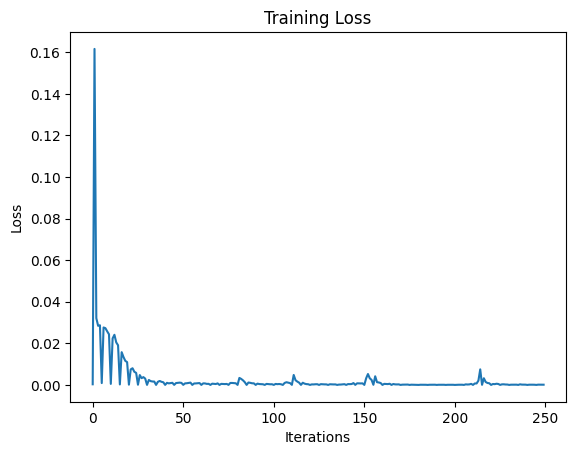

In [ ]:
# Initialize the loss
losses = []

# Training loop
num_epochs = 50  # Set the number of epochs
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, wind_speeds) in enumerate(train_loader, 0):
        # Transfer to GPU if available
        images, wind_speeds = images.to(device), wind_speeds.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = cnn_model(images)
        loss = criterion(outputs, wind_speeds.float().unsqueeze(1))
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

        # Record the average loss every 50 mini-batches
        if i % 50 == 0:
            avg_loss = running_loss / 50
            losses.append(avg_loss)
            print(f'epoch: {epoch + 1}, iteration: {i + 1:5d}, loss: {avg_loss:.3f}')
            running_loss = 0.0

model_path = './drive/MyDrive/cnn_model.pth'
torch.save(cnn_model.state_dict(), model_path)

print('Finished Training')

# Plot losses
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

## 5.Model Evaluation


Calculate the total loss of the testset

In [ ]:
cnn_model.eval()
test_loss = 0.0

with torch.no_grad():
    for images, wind_speeds in test_loader:
        images, wind_speeds = images.to(device), wind_speeds.to(device)
        outputs = cnn_model(images)

        # Assuming outputs and wind_speeds are your model output and target tensors respectively
        outputs = outputs.view(-1)  # Reshape outputs to be a 1D tensor if not already
        wind_speeds = wind_speeds.view(-1)  # Flatten wind_speeds to match outputs shape

        # Now calculate the loss
        loss = criterion(outputs, wind_speeds)

        test_loss += loss.item()
        print("test_loss: ", test_loss)

test_loss:  0.0003672392011272452
test_loss:  0.0013912001119656976
test_loss:  0.0016629992225905932
test_loss:  0.0019663034598300447
test_loss:  0.0020669189697164847
test_loss:  0.0032380691950810174
test_loss:  0.0034356636549333726
test_loss:  0.003626471049330024
test_loss:  0.003939558267657758
test_loss:  0.004163962833789035
test_loss:  0.0044549647618795625
test_loss:  0.004597859486075686
test_loss:  0.0049985777119739925
test_loss:  0.005172626960148171
test_loss:  0.005321626319217365
test_loss:  0.005953029333040855
test_loss:  0.006164910699298161
test_loss:  0.006434972623103273
test_loss:  0.006528904194987035
test_loss:  0.012619333570105085
test_loss:  0.012924906752805927
test_loss:  0.013790423064645705
test_loss:  0.01837044859933516
test_loss:  0.018650828936984772
test_loss:  0.019483789657081443
test_loss:  0.02002707407280604
test_loss:  0.020272844770385375
test_loss:  0.020386109959507764
test_loss:  0.020616443440432015
test_loss:  0.020737277817004126
tes

We use 1906 images for testing. After calculating the loss, we visualize the performance of the model. The plot is a comparison between actual wind speeds and predicted wind speeds of the first 100 images in the testset.

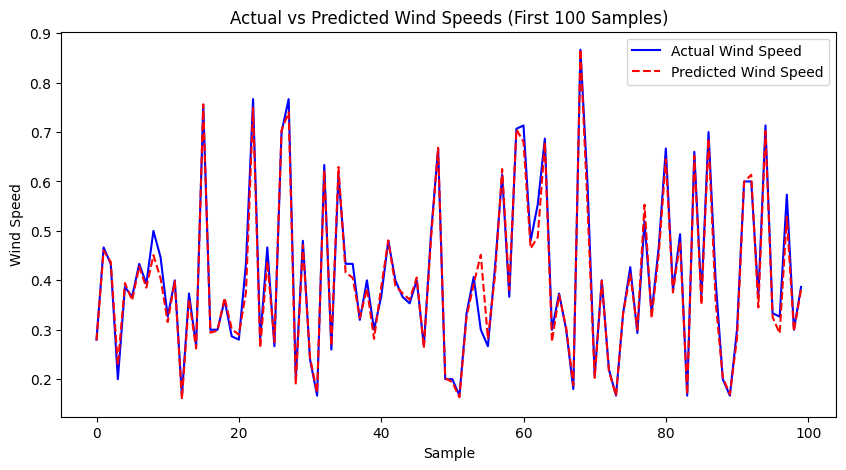

In [ ]:
import numpy as np

# Assuming test_loader is defined and cnn_model is trained and sent to the correct device
cnn_model.eval()  # Set the model to evaluation mode

# Lists to store actual and predicted wind speeds for the first 100 samples
actual_speeds = []
predicted_speeds = []

with torch.no_grad():
    for i, (images, wind_speeds) in enumerate(test_loader):
        if i * test_loader.batch_size >= 100:
            break  # Break after processing 100 samples
        images, wind_speeds = images.to(device), wind_speeds.to(device)
        outputs = cnn_model(images)
        # Store actual and predicted values for plotting
        actual_speeds.extend(wind_speeds.cpu().numpy())
        predicted_speeds.extend(outputs.cpu().numpy())

# Convert lists to arrays for plotting
actual_speeds = np.array(actual_speeds)[:100]  # Select the first 100 elements
predicted_speeds = np.array(predicted_speeds).flatten()[:100]  # Select the first 100 elements and flatten

# Plot actual vs predicted wind speeds for the first 100 samples
plt.figure(figsize=(10, 5))
plt.plot(actual_speeds, label='Actual Wind Speed', color='blue')
plt.plot(predicted_speeds, label='Predicted Wind Speed', color='red', linestyle='--')
plt.title('Actual vs Predicted Wind Speeds (First 100 Samples)')
plt.xlabel('Sample')
plt.ylabel('Wind Speed')
plt.legend()
plt.show()




The blue solid line represents the actual wind speeds as observed or measured, while the red dashed line depicts the wind speeds as predicted by a model.

The graph indicates a close match between the two lines, suggesting that the predictions closely mirror the actual observations. This implies that the predictive model has performed very well on this subset of data. The lines frequently overlap, and the pattern of peaks and troughs is almost identical, which indicates a high degree of accuracy in the model's predictions.

In summary, the plot demonstrates an effective predictive performance, with the model's predictions aligning closely with the actual wind speeds across the samples presented.

Since wind speed is normalized in our dataframe, we need to convert them back.

In [ ]:
# Lists to store actual and predicted wind speeds
actual_speeds = []
predicted_speeds = []

with torch.no_grad():
    for images, wind_speeds in test_loader:
        images, wind_speeds = images.to(device), wind_speeds.to(device)
        outputs = cnn_model(images)

        outputs = outputs.view(-1)  # Reshape outputs to be a 1D tensor if not already
        wind_speeds = wind_speeds.view(-1)  # Flatten wind_speeds to match outputs shape

        # Store scaled actual and predicted values for output to CSV
        actual_speeds.extend((wind_speeds.cpu().numpy() * max_wind_speed).tolist())
        predicted_speeds.extend((outputs.cpu().numpy() * max_wind_speed).round().tolist())


The evaluation metric we use is Mean Squared Error (MSE). Calculate the mse of the whole testset, which includes 1906 images. We use MSE because it is consistent with varience, so we can easily measure the performance of our model.

In [ ]:
from sklearn.metrics import mean_squared_error

# Calculate Mean Squared Error (MSE) between actual and predicted wind speeds
mse = mean_squared_error(actual_speeds, predicted_speeds)
mse

12.486358866736621

The model got a very low MSE over 1906 testing images, which indicates an effective predictive performance. The model's predictions aligning closely with the actual wind speeds across the samples presented.

## 6.Model Comparison

The model and training configuration shown above produced the best experimental results. To obtain this model, we conduct a series of experiments. In this part, we illustrate the reasons of choosing this model, the performance of other models and why this model out perform.

We explain our experiments in four aspects: **model selection**, **transformation method**, **channel number selection**, and **generalization ability**.

### 6.1 Model Selection

To predict wind speed perfectly, we trained several models, including models defined by ourselves, and some state-of-the-art pretrained models. We trained all the models by ourselves with 10 epoches, and used MSE over 1906 testing images as the criterion of comparison. The following table shows models we have tried and their performances.

| Model | MSE
| --- | ---
| 3-Layer CNN | 80.46
| ResNet18 | 41.34
| MobileNetv3_large | 49.14
| MobileNetv3_small | 60.24
| Efficient_b0 | 16.16
| **6-Layer CNN** | **12.49**


1. **3-Layer CNN**

First we used a simple 3 layer CNN, with no max pooling layer, batch normalization and drop out layer. The 3-layer CNN might yield poor performance for generalizing storm features from multiple storms, which constrains its ability to capture complex, hierarchical patterns and features that are often crucial for accurately interpreting meteorological data. The complexity and subtlety of visual cues in storm imagery, which can indicate wind speed, require a deeper network architecture with more layers to effectively extract and learn from.

However, it is suitable for a specific model for only one storm. Because it has the ability to extract homogeneous information, which is useful for forecasting against one type of storms.

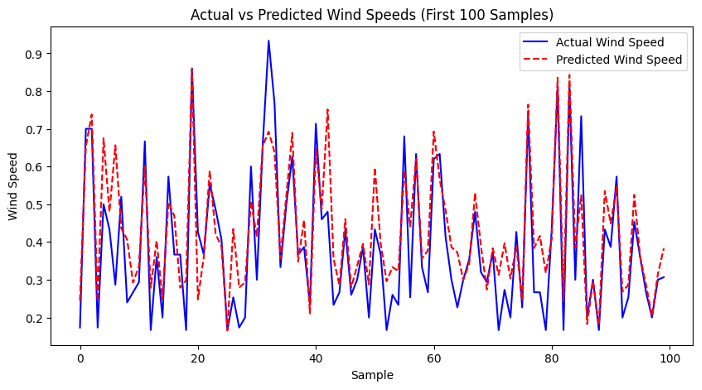

2. **ResNet18**

We also tried ResNet18, which is a pretrained model. To adjust it to fit our model, we modified the input Layer. Since storm images come as single-channel grayscale images, the first convolutional layer of the pre-trained ResNet18 model is modified to accept a single-channel input. This is done by changing the in_channels parameter of the conv1 layer from 3 (default for RGB images) to 1.

The final fully connected layer (fc) is replaced to suit the specific task of wind speed prediction, which is a regression task. The new fc layer outputs a single value representing the wind speed, which corresponds to num_classes=1 in this case. ResNet-18 does not perform optimally in predicting wind speeds from storm images for several reasons.

1. Firstly, while deeper than a 3-layer CNN, ResNet-18 may still lack sufficient depth to capture the full complexity of storm patterns that correlate with wind speeds.

2. Besides, the pre-training domain may have mismatched our task. The ResNet-18 is pre-trained on a dataset like ImageNet, the features learned might not transfer well to the specific domain of storm imagery, which can be significantly different.

3. Finally, important details might be lost in earlier pooling layers of the network, which can lead to inadequate feature representation for accurate wind speed prediction.


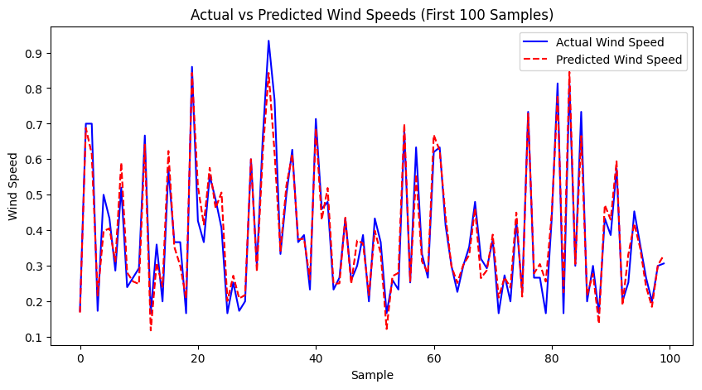

3. **MobileNetv3**

We also customized the MobileNetV3 Large and Small models for predicting wind speed from storm images. The first convolutional layer of MobileNetV3 Large is modified to accept a single-channel (grayscale) input instead of the default three-channel (RGB) input. Then the classifier layer is replaced with a new linear layer that outputs a single value corresponding to the wind speed, which is a regression task. This is done by setting num_classes=1, which matches the requirement for predicting a continuous variable like wind speed.

We analysed the reasons why MobileNetV3 does not perform well for this specific task as follows.

1. MobileNetV3 is designed to be lightweight and efficient, which means sacrificing some representational power that might be necessary for capturing complex features in storm images related to wind speed prediction.

2. The same as ResNet18, the pre-training on ImageNet may not transfer well to storm images if the features in storm images that correlate with wind speed are significantly different from the natural image features that MobileNetV3 has learned.

3. Besides, MobileNetV3's architecture, while generally effective for a wide range of tasks, might not be ideal for the specific nuances of meteorological data. Without fine-tuning the model on a substantial and representative dataset of storm images with corresponding wind speeds, the pre-trained model might not adapt adequately to the new domain.

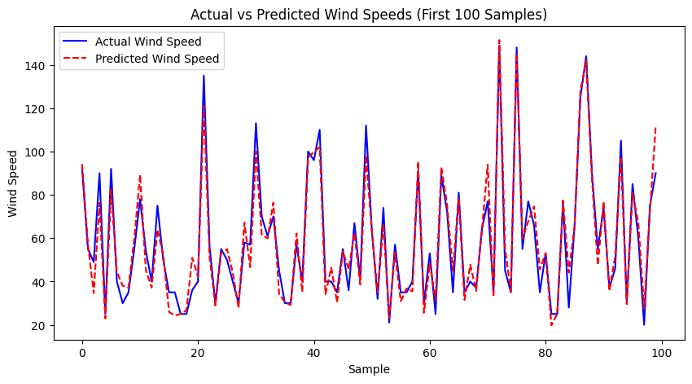

4. **Efficient_b0**

We adapted EfficientNetB0 model for wind speed prediction from storm images by modifying its final classification layer. According to MSE above, this model perform better than previous models. We analyze the reasons:

1. EfficientNet-B0 is part of the EfficientNet family, which is known for its balance between accuracy and computational efficiency. The architecture uses a compound scaling method that uniformly scales the depth, width, and resolution of the network layers, potentially allowing it to capture more complex patterns with fewer parameters compared to models like ResNet and MobileNet.

2. Besides, EfficientNet-B0 was designed using a neural architecture search that optimized its layers for performance, which can make it more capable of handling the intricacies of storm images and the nuances related to wind speed.

3. It can extract detailed features from images at multiple scales due to its compound scaling, which may help in better capturing the subtle cues in storm imagery that are indicative of wind speed.


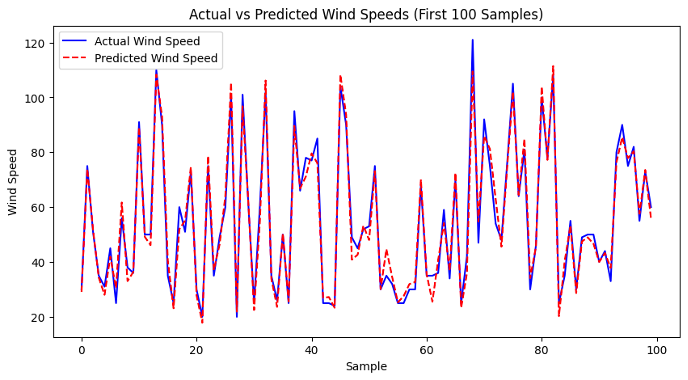

5. **6-Layer CNN**

The best model is the 6-layer CNN designed by ourselves. The Simple6LayerCNNv3 model's superior performance with the lowest MSE can be attributed to several key factors:

1. **Optimal Depth**: With six convolutional layers, the model has sufficient depth to capture complex patterns in storm images, essential for accurate wind speed prediction.

2. **Batch Normalization**: This feature, present after each convolutional layer, aids in stabilizing the training process by normalizing the inputs, leading to faster convergence and more effective learning.

3. **ReLU Activations**: The use of ReLU (Rectified Linear Unit) introduces non-linearity, enabling the model to learn more complex relationships in the data.

4. **Effective Pooling**: Max pooling layers reduce the spatial dimensions of the feature maps, which helps in reducing the computation load and extracting key features while minimizing the risk of overfitting.

5. **Dropout Regularization**: The inclusion of a dropout layer before the final fully connected layer is crucial for reducing overfitting, ensuring that the model does not rely too heavily on any single node and learns more robust features.

6. **Robust Fully Connected Layers**: The series of fully connected layers are critical for making the final wind speed prediction, utilizing the high-level features processed by the convolutional layers.

7. **Model Architecture Suitability**: The overall architecture of the model, encompassing the sequence and structure of layers, appears to be well-suited for the task at hand. It effectively balances the need for model complexity to capture relevant patterns in the data with the need to prevent overfitting.

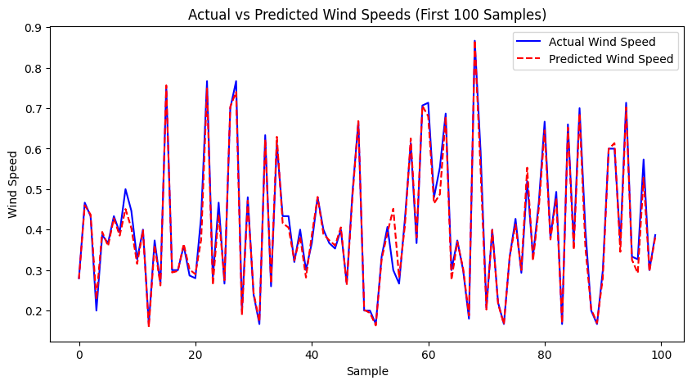

### 6.2 Transformation method

To predict wind speed perfectly, we also trained models with different image transformations. We trained all the models by ourselves with 10 epoches, and used MSE over 1906 testing images as the criterion of comparison.  The following table shows transformations we have tried and their performances.

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize the image to 128x128
    # transforms.RandomRotation(degrees=15),  # Randomly rotate the image by +/- 15 degrees
    # transforms.RandomHorizontalFlip(p=0.2),  # Randomly flip the image horizontally with a probability of 0.5
    # transforms.RandomVerticalFlip(p=0.2),  # Randomly flip the image vertically with a probability of 0.5
    # transforms.ColorJitter(contrast=0.5),  # Randomly change the contrast of the image
    # transforms.RandomResizedCrop(128, scale=(0.8, 1.0), ratio=(0.75, 1)),  # Randomly crop and resize the image
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    # transforms.CenterCrop(256),  # Crop the image to 128x128 at the center
    # transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),  # Normalize the tensor
    transforms.Normalize(mean=[0.485], std=[0.229]),  # Normalize the tensor
])

| Model | MSE(simple transform) | MSE(complex transform)
| --- | --- | ---
| ResNet18 | 41.34 | 200.65
| MobileNetv3_large | 49.14 | 172.79
| Efficient_b0 | 16.16 | 40.76
| **6-Layer CNN** | **12.49** | 91.48

In our recent experiments using various neural network architectures, including EfficientNetB0, MobileNetV3, ResNet18, and a custom 6-layer CNN, we explored the impact of different image transformations on the model's performance for our specific dataset and task. We defined two sets of transformations: a simpler one and a more complex one.

The simpler transformation, which we ultimately found to be more effective for our needs, involved basic operations such as **resizing the images to 128x128 pixels and normalizing them.** This approach is encapsulated in our transform function.

In contrast, the complex transformation included additional steps like **random rotations, horizontal and vertical flips, contrast adjustments, and random cropping. **However, through extensive testing, we discovered that the simpler transformation yielded better results for our dataset and task.

This finding suggests that for our specific application, basic preprocessing steps were sufficient and more beneficial than introducing variability through complex transformations.


We analyzed and thought several reasons:

1. **Focus on Essential Features**: Simple transformations like resizing and normalization maintain the fundamental characteristics of storm images. Complex transformations might introduce unnecessary variability or distort important features, making it harder for the model to learn the crucial patterns related to wind speed.

2. **Data Fidelity**: Storm images often contain subtle yet critical details that indicate wind speed. Simple transformations preserve these details, whereas additional manipulations like random rotations or flips might obscure or alter them, leading to a loss of crucial information. For example, random crop may leave the important features in the corner of storm images.

3. **Alignment with Image Nature**: Storm images are specific in that their key indicators of wind speed (like cloud formations or wave patterns) are naturally occurring and have a specific orientation. Random flips or rotations might disrupt these patterns, leading to misleading training data.

### 6.3 Channel number selection

We also tried different channel number input, whether 3-channel RGB or 1-channel Grayscale. We trained all the models by ourselves with 10 epoches, and used MSE over 1906 testing images as the criterion of comparison. The following table shows chennel numbers we have tried and their performances.

| Model | MSE(RGB) | MSE(Grayscale)
| --- | --- | ---
| Efficient_b0 | 16.16 | 41.34
| **6-Layer CNN** | 217.09 | **12.49**

In our comparative analysis using EfficientB0 and the 6-layer CNN—two models that emerged as top performers in our earlier assessments, we discovered that models trained with single-channel (grayscale) input achieved lower Mean Squared Error (MSE) and better training outcomes compared to those trained with three-channel (RGB) input. The reasons for this improved performance are:

1. **Data Relevance**: Storm images do not require the color information that three channels provide. Grayscale images retain critical structural details relevant for wind speed prediction, and dropping the color channels reduces noise and unnecessary information.

2. **Model Focus**: By providing single-channel input, we direct the model's capacity to focus on texture and shape patterns important for wind speed predictions, rather than distributing its capacity across color channels that may not contribute to performance.

3. **Training Efficiency**: Single-channel inputs reduce the computational load, leading to faster training times and allowing the model to converge more quickly on the relevant features that determine wind speed.


### 6.4 Generalization ability

Among the models tested—3-layer CNN, ResNet18, MobileNetV3_Large, EfficientB0, and a 6-layer CNN, the **6-layer CNN** demonstrated the best generalization ability. The reasons for its superior performance are as follows:

1. **Architectural Advanvage**: The 6-layer CNN has architectural depth—enough layers to capture complex patterns, unlike deeper networks that might learn noise. With six layers, the model can effectively build a hierarchy of features from simple to complex, capturing essential information for wind speed prediction.

2. **Batch Normalization**: The inclusion of batch normalization after each layer helps the model generalize better by reducing internal covariate shift, leading to a more stable and faster training process.

3. **Dropout Regularization**: The dropout layers within the 6-layer CNN prevent the model from relying too heavily on any single feature, promoting robustness to new data.

4. **Sufficient Model Capacity**: This model has enough parameters to learn from the data but not so many that it becomes prone to overfitting, unlike potentially larger models like EfficientB0.

## 7.Conclusion

For the task of predicting wind speeds from storm images, our study concluded that a **6-layer CNN model** was the most effective. Utilizing a dataset comprising images from 30 different storms, we trained our model and achieved commendable results. The **Mean Squared Error** (MSE) from our predictions indicated a high level of accuracy, and the plots visualizing actual versus predicted wind speeds showcased the model's robust predictive capability. This outcome highlights the 6-layer CNN's ability to extract and learn meaningful patterns from complex meteorological data.

# Method 2: Prediction based on time sequence and previous wind speed

## 1. Data Preprocessing

In this case we did not normalize the wind speeds as we were afraid that MSE loss would not properly work for values less than 1.

On the other hand, we decided to interpolate the values between non-uniform timesteps and rounded all timesteps to multiples of 1800s.

Everything is already packaged in forecaster.wind_speed_lstm but we shall copy it below for ease of access.  

In [ ]:
def interpolate_df(df, timestep=1800):
    """
    Interpolates missing values in a DataFrame for each unique storm.

    Args:
        df (pandas.DataFrame): The input DataFrame containing storm data.
        timestep (int, optional): The time step in seconds. Defaults to 1800.

    Returns:
        pandas.DataFrame: The interpolated DataFrame.

    """
    unique_storms = df['storm_id'].unique() # reads the different values of storm ids
    interpolated_dfs = []

    # iterates through each storm
    for storm in unique_storms:
        storm_df = df.loc[df['storm_id']==storm]

        # rounds timesteps to the nearest multiple
        storm_df.loc[:, 'relative_time'] = storm_df['relative_time'].apply(lambda x: round(x/timestep))

        # creates the missing timesteps
        complete_timestamps = pd.DataFrame({'relative_time': range(int(storm_df['relative_time'].min()), int(storm_df['relative_time'].max()) + 1)})

        # adds the new rows to the storm dataframw
        merged_df = pd.merge(complete_timestamps, storm_df, on='relative_time', how='left')

        # interpolates the missing wind speeds
        merged_df['wind_speed'] = merged_df['wind_speed'].interpolate(method='linear')

        # fills NaNs
        merged_df['ocean'] = storm_df['ocean'].iloc[0]
        merged_df['storm_id'] = storm
        merged_df['relative_time'] *= timestep
        interpolated_dfs.append(merged_df)

    # concatenates the storm dfs
    interpolated_df = pd.concat(interpolated_dfs)
    return interpolated_df



## 2. Data Loading

In order to predict the future, our features will be a subset of the timeseries, and the target a shifted subset. The function below outputs all such pairs for a specific timeseries, with a variable lookback and shift.

In [ ]:
def create_dataset(dataset, lookback, shift=1):
    """
    Create a dataset for time series forecasting.

    Args:
        dataset (list or numpy.ndarray): The input time series data.
        lookback (int): The number of previous time steps to use as features.
        shift (int, optional): The number of time steps to shift the target.
            Defaults to 1.

    Returns:
        tuple: A tuple containing the input features (X) and the corresponding
            target values (y).
    """
    X, y = [], []
    # loops over all possible start locations for an input
    for i in range(len(dataset) - lookback - shift + 1):
        # extracts feature and target
        feature = dataset[i : i + lookback]
        target = dataset[i + shift : i + lookback + shift]
        X.append(feature)
        y.append(target)
    return torch.tensor(np.array(X)), torch.tensor(np.array(y))

We shall now use the code from above in order to make pytorch data loaders to train our model.  

In [ ]:
def df_to_loaders(
    df, lookback=20, shift=1, train_batch_size=32, test_batch_size=200, train_ratio=0.8
):
    """
    Converts a DataFrame into PyTorch DataLoader objects for training and testing.

    Args:
        df (pandas.DataFrame): The input DataFrame containing the time series data.
        lookback (int, optional): The number of previous time steps to include in the
            input sequence. Defaults to 20.
        shift (int, optional): The number of time steps to shift the target variable.
            Defaults to 1.
        train_batch_size (int, optional): The batch size for the training DataLoader.
            Defaults to 32.
        test_batch_size (int, optional): The batch size for the testing DataLoader.
            Defaults to 200.
        train_ratio (float, optional): The ratio of data to use for training.
            Defaults to 0.8.

    Returns:
        tuple: A tuple containing the training DataLoader and testing DataLoader.
    """
    # Load the dataframe
    int_df = interpolate_df(df)
    unique_storms = int_df["storm_id"].unique()
    timeseries_list = [
        int_df.loc[int_df["storm_id"] == storm_id, ["wind_speed"]].values.astype("float32")
        for storm_id in unique_storms
    ]

    # Get features and targets for all storms and merge them
    X, y = [], []
    for timeseries in timeseries_list:
        X_, y_ = create_dataset(timeseries, lookback=lookback, shift=shift)
        X.append(X_)
        y.append(y_)
    X = torch.cat(X)
    y = torch.cat(y)

    # Shuffle them
    indices = torch.randperm(len(X))
    X = X[indices]
    y = y[indices]

    # Train-test split
    X_train, y_train = X[: int(len(X) * train_ratio)], y[: int(len(X) * train_ratio)]
    X_test, y_test = X[int(len(X) * train_ratio) :], y[int(len(X) * train_ratio) :]

    # Convert to torch data loaders
    train_loader = data.DataLoader(
        data.TensorDataset(X_train, y_train), batch_size=train_batch_size, shuffle=True
    )
    test_loader = data.DataLoader(
        data.TensorDataset(X_test, y_test), batch_size=test_batch_size, shuffle=False
    )

    return train_loader, test_loader

## 3. Model Architecture

We opted for a simple LSTM for our model as it provided quite good results. The architecture can be found below.

In [ ]:
class WindModel(nn.Module):
    """
    A PyTorch module for wind prediction.

    Args:
        hidden_size (int): The number of features in the hidden state of the LSTM.
        num_layers (int): The number of recurrent layers in the LSTM.

    Attributes:
        lstm (nn.LSTM): The LSTM layer for sequence modeling.
        linear (nn.Linear): The linear layer for output prediction.
    """

    def __init__(self, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

## 4. Model Training

We decided to add a loss window in order to focus less on predicting the common values of the input and the output and focus more on predicting the future.

In [ ]:
def train(model, optimizer, criterion, data_loader, loss_window=0):
    """
    Trains the model using the given optimizer and criterion on the
        provided data_loader.

    Args:
        model (nn.Module): The model to be trained.
        optimizer (torch.optim.Optimizer): The optimizer used for training.
        criterion (torch.nn.Module): The loss function used for training.
        data_loader (torch.utils.data.DataLoader): The data loader for training data.
        loss_window (int, optional): The number of time steps to consider for
            loss calculation. Defaults to 0.

    Returns:
        float: The average training loss.
    """
    model.train()
    train_loss = 0
    for batch_idx, (X, y) in enumerate(data_loader):
        optimizer.zero_grad()
        output = model(X)
        loss = torch.sqrt(criterion(output[:, -loss_window:, :], y[:, -loss_window:, :]))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(data_loader)

In [ ]:
def validate(model, criterion, data_loader, loss_window=0):
    """
    Validates the model using the given criterion and data loader.

    Args:
        model (torch.nn.Module): The model to be validated.
        criterion (torch.nn.Module): The criterion used for calculating the loss.
        data_loader (torch.utils.data.DataLoader): The data loader for loading
            the validation data.
        loss_window (int, optional): The number of time steps to consider for
            calculating the loss. Defaults to 0, i.e. considering all time steps.

    Returns:
        float: The average test loss over the validation data.
    """
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(data_loader):
            output = model(X)
            loss = torch.sqrt(criterion(output[:, -loss_window:, :], y[:, -loss_window:, :]))
            test_loss += loss.item()
    return test_loss / len(data_loader)

The train_model function trains the model for a set number of epochs and outputs the model from the epoch with the lowest validation loss. The loss plot outputted is in log scale in order to better view the nuances at the smaller values.

In [ ]:
def train_model(
    model, optimizer, criterion, train_loader, test_loader, epochs, loss_window=0
):
    """
    Trains a model using the specified optimizer and criterion
        for the specified number of epochs.

    Args:
        model (torch.nn.Module): The model to be trained.
        optimizer (torch.optim.Optimizer): The optimizer used for training.
        criterion (torch.nn.Module): The loss function used for training.
        train_loader (torch.utils.data.DataLoader): The data loader for
            the training dataset.
        test_loader (torch.utils.data.DataLoader): The data loader for
            the test dataset.
        epochs (int): The number of epochs to train the model.
        loss_window (int, optional): The size of the loss window for
            tracking the average loss.
            Defaults to 0, which means considering all time steps.

    Returns:
        dict: The state dictionary of the best model based on the validation loss.
    """
    best_loss = np.inf
    best_model = None

    liveloss = PlotLosses()
    for epoch in range(epochs):
        logs = {}
        train_loss = train(
            model, optimizer, criterion, train_loader, loss_window=loss_window
        )
        test_loss = validate(model, criterion, test_loader, loss_window=loss_window)
        logs["loss"] = np.log(train_loss)
        logs["val_loss"] = np.log(test_loss)
        liveloss.update(logs)
        liveloss.send()

        if test_loss < best_loss:
            best_loss = test_loss
            best_model = model.state_dict()

    return model.load_state_dict(best_model)

Below is a sample of how to train a model.

In [ ]:
model = wp.WindModel(hidden_size=32, num_layers=1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

train_loader, test_loader = wp.df_to_loaders(final_df, lookback=5, shift=1, train_batch_size=32, test_batch_size=200, train_ratio=0.8)
best_model = wp.train_model(model, optimizer, criterion, train_loader, test_loader, epochs=100)

## 5. Model selection

We considered several models of various architectures, learning rates, lookback, shift and loss windows.

Hidden size and number of layers did not seem to change the output too much and therefore 64 and 3 were chosen respectively.

The default learning rate of 0.001 seemed to work the best, converging relativelty quickly to the noise floor, and still recreasing a bit after then.

Lookback did not seem to affect the output much either so we decided to go for a lookback of 20.

A shift of more than 1 led to a higer MSE, so it was not as good as predicting the exact next step, but when comparing models with different shifts in how they would predict many steps into the future (5+), models with larger shifts did better overall.

A change in loss window seemed to confuse the model resulted in weird results.

## 6. Predicting the future

In order to predict the future that is more than the shift, we iteratively drop the first value of the input and append to it the first predicted value.

In [ ]:
def predict_future(model, list, future_steps, next_future=-1):
    """
    Predicts the future values using the given model and input list.

    Args:
        model (torch.nn.Module): The trained model used for prediction.
        list (torch.Tensor): The input list of values.
        future_steps (int): The number of future steps to predict.
        next_future, the value of the first step after the input

    Returns:
        list: A list of predicted future values.
    """
    future = []
    model.eval()
    with torch.no_grad():
        for i in range(future_steps):
            output = model(list)[:, next_future, :].unsqueeze(1)
            future.append(float(output.flatten().__getitem__(0)))
            list = torch.cat((list[:, 1:, :], output), dim=1)
    return future

Below is some sample code on how to use it.

In [ ]:
predict_future(model, torch.tensor(np.array([50, 51, 52, 52, 53]).astype('float32')).unsqueeze(0).unsqueeze(2), 10)